In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Concatenate, Input, Flatten, Lambda, Reshape
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import plot_model

In [3]:
df = pd.read_csv('./car.data', header=None)
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "target"]
categorical_vars = df.columns[:-1]
for cat_var in df.columns:
	df[cat_var] = df[cat_var].astype("category")

In [4]:
for cat_var in df.columns:
	print(cat_var, dict(enumerate(df[cat_var].cat.categories)))
	df[cat_var] = df[cat_var].cat.codes

buying {0: 'high', 1: 'low', 2: 'med', 3: 'vhigh'}
maint {0: 'high', 1: 'low', 2: 'med', 3: 'vhigh'}
doors {0: '2', 1: '3', 2: '4', 3: '5more'}
persons {0: '2', 1: '4', 2: 'more'}
lug_boot {0: 'big', 1: 'med', 2: 'small'}
safety {0: 'high', 1: 'low', 2: 'med'}
target {0: 'acc', 1: 'good', 2: 'unacc', 3: 'vgood'}


In [5]:
print(df.shape)
df.head()

(1728, 7)


,buying,maint,doors,persons,lug_boot,safety,target
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [6]:
df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index, axis=0)


X_train = df_train.drop("target", axis=1)
y_train = df_train["target"].values

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"].values

In [7]:
X_train_preprocessed = []
for c in X_train.columns:
	X_train_preprocessed.append(X_train[c].to_numpy())
X_test_preprocessed = []
for c in X_test.columns:
	X_test_preprocessed.append(X_test[c].to_numpy())

## Using only one predictor

In [8]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
embedding_size = 3

model = Sequential()
model.add(Embedding(input_dim = 4, output_dim = embedding_size, input_length = 1, name="embedding"))
model.add(Flatten())
for _ in range(4):
	model.add(Dense(200, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
history = model.fit(x=X_train["buying"].to_numpy(), y=y_train, epochs = 50, batch_size = 4, callbacks=[callback])


Epoch 1/50


2022-05-16 23:37:34.399669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


346/346 [==============================] - 1s 1ms/step - loss: 0.9734 - accuracy: 0.6932
Epoch 2/50
346/346 [==============================] - 1s 2ms/step - loss: 0.8259 - accuracy: 0.6946
Epoch 3/50
346/346 [==============================] - 1s 1ms/step - loss: 0.8056 - accuracy: 0.6946
Epoch 4/50
346/346 [==============================] - 0s 1ms/step - loss: 0.7987 - accuracy: 0.6946
Epoch 5/50
346/346 [==============================] - 1s 2ms/step - loss: 0.7923 - accuracy: 0.6946


## Using all predictors

In [9]:
embedding_size = 4
ins = []
embedded_models = []
for cat_var in categorical_vars:
	_input = Input(shape=(1,), name=cat_var)
	ins.append(_input)
	k = df_train[cat_var].nunique()
	_embedded = Embedding(k+1, embedding_size, input_length=1, name=cat_var + "_embedded")(_input)
	embedded_models.append(_embedded)
x = Concatenate()(embedded_models)
x = Flatten()(x)
for _ in range(4):
	x = Dense(200, activation="relu")(x)
outs = Dense(4, activation="softmax")(x)
model = keras.Model(inputs=ins, outputs=outs)

In [10]:
model.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(x=X_train_preprocessed, y=y_train, epochs = 50, batch_size = 4, callbacks=[callback], validation_split=0.1)

Epoch 1/50
311/311 [==============================] - 2s 3ms/step - loss: 0.9742 - accuracy: 0.6822 - val_loss: 0.7003 - val_accuracy: 0.7122
Epoch 2/50
311/311 [==============================] - 1s 2ms/step - loss: 0.5292 - accuracy: 0.7522 - val_loss: 0.3881 - val_accuracy: 0.8201
Epoch 3/50
311/311 [==============================] - 1s 2ms/step - loss: 0.3007 - accuracy: 0.8713 - val_loss: 0.2797 - val_accuracy: 0.8417
Epoch 4/50
311/311 [==============================] - 1s 2ms/step - loss: 0.2323 - accuracy: 0.8922 - val_loss: 0.2371 - val_accuracy: 0.8993
Epoch 5/50
311/311 [==============================] - 1s 2ms/step - loss: 0.1975 - accuracy: 0.9212 - val_loss: 0.2351 - val_accuracy: 0.9065
Epoch 6/50
311/311 [==============================] - 1s 3ms/step - loss: 0.1843 - accuracy: 0.9204 - val_loss: 0.2073 - val_accuracy: 0.9065
Epoch 7/50
311/311 [==============================] - 1s 2ms/step - loss: 0.1689 - accuracy: 0.9228 - val_loss: 0.2201 - val_accuracy: 0.9209
Epoch 

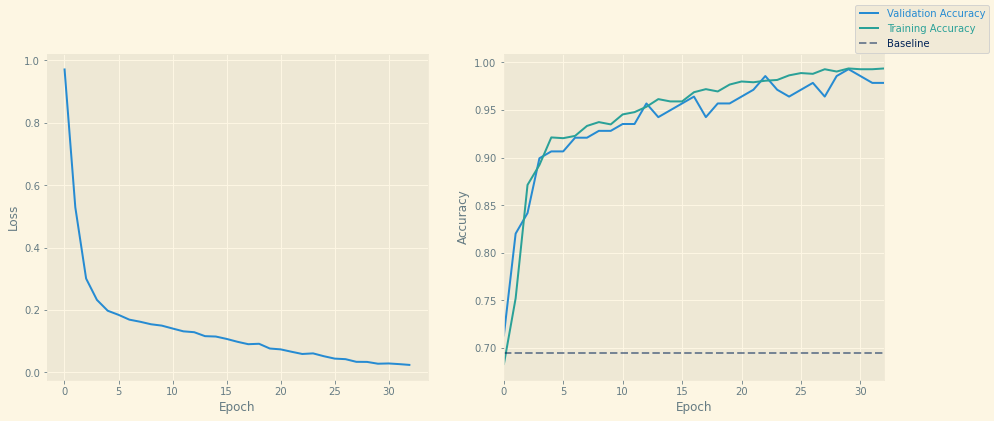

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(history.history["loss"])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlim(left=0, right=history.epoch[-1])
baseline_acc = (np.bincount(y_train) / len(y_train)).max().round(3)
axs[1].axhline(baseline_acc, ls='--', label='Baseline', color='#002255', alpha=0.5)
fig.legend(labelcolor='linecolor')

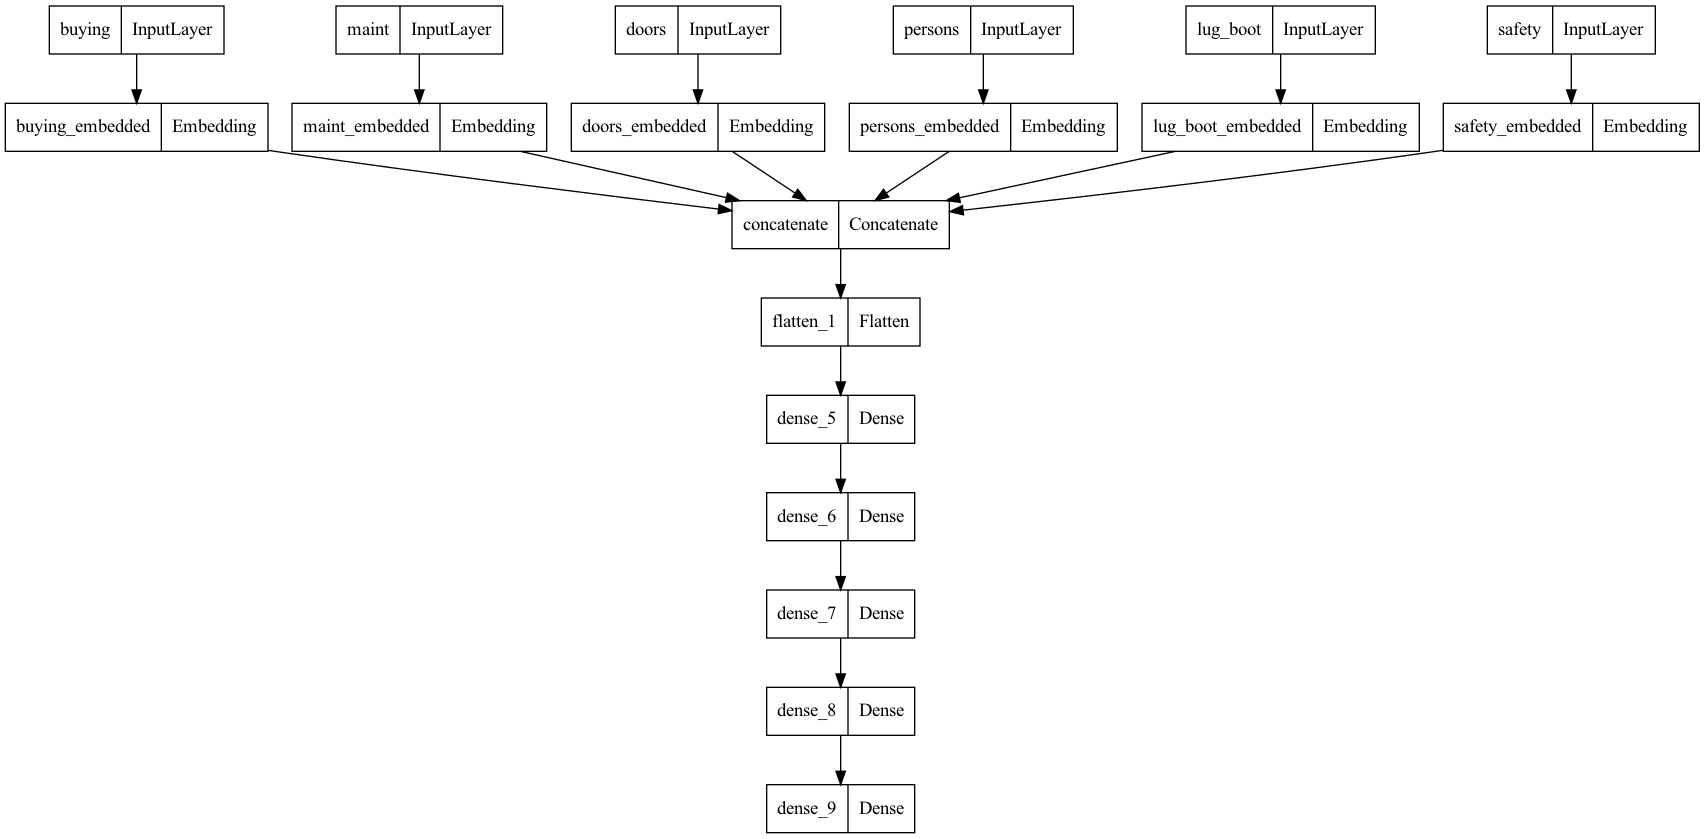

In [13]:
plot_model(model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 buying (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 maint (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 doors (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 persons (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

## Testing on Lambda layer (for scalar multiplication)

In [15]:
embedding_size = 4
ins = []
sub_models = []
for cat_var in categorical_vars:
	_input = Input(shape=(1,), name=cat_var)
	ins.append(_input)
	k = df_train[cat_var].nunique()
	_embedded = Embedding(k+1, embedding_size, input_length=1, name=cat_var + "_embedded")(_input)
	_embedded = Reshape(target_shape=(embedding_size,))(_embedded)
	sub_model = Lambda(lambda x: tf.multiply(x[0], x[1]), name=cat_var + "_mult")([_input, _embedded])
	sub_models.append(sub_model)
x = Concatenate()(sub_models)
for _ in range(4):
	x = Dense(200, activation="relu")(x)
outs = Dense(4, activation="softmax")(x)
model = keras.Model(inputs=ins, outputs=outs)

In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 buying (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 maint (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 doors (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 persons (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(x=X_train_preprocessed, y=y_train, epochs = 50, batch_size = 4, callbacks=[callback], validation_split=0.1)

Epoch 1/50
311/311 [==============================] - 2s 3ms/step - loss: 0.9404 - accuracy: 0.6814 - val_loss: 0.7434 - val_accuracy: 0.7122
Epoch 2/50
311/311 [==============================] - 1s 2ms/step - loss: 0.6367 - accuracy: 0.7128 - val_loss: 0.4810 - val_accuracy: 0.8201
Epoch 3/50
311/311 [==============================] - 1s 2ms/step - loss: 0.4124 - accuracy: 0.8254 - val_loss: 0.3544 - val_accuracy: 0.8345
Epoch 4/50
311/311 [==============================] - 1s 2ms/step - loss: 0.3289 - accuracy: 0.8624 - val_loss: 0.3025 - val_accuracy: 0.8633
Epoch 5/50
311/311 [==============================] - 1s 2ms/step - loss: 0.2762 - accuracy: 0.8761 - val_loss: 0.2645 - val_accuracy: 0.8777
Epoch 6/50
311/311 [==============================] - 1s 2ms/step - loss: 0.2335 - accuracy: 0.8850 - val_loss: 0.2314 - val_accuracy: 0.8921
Epoch 7/50
311/311 [==============================] - 1s 2ms/step - loss: 0.2002 - accuracy: 0.9139 - val_loss: 0.1982 - val_accuracy: 0.9281
Epoch 

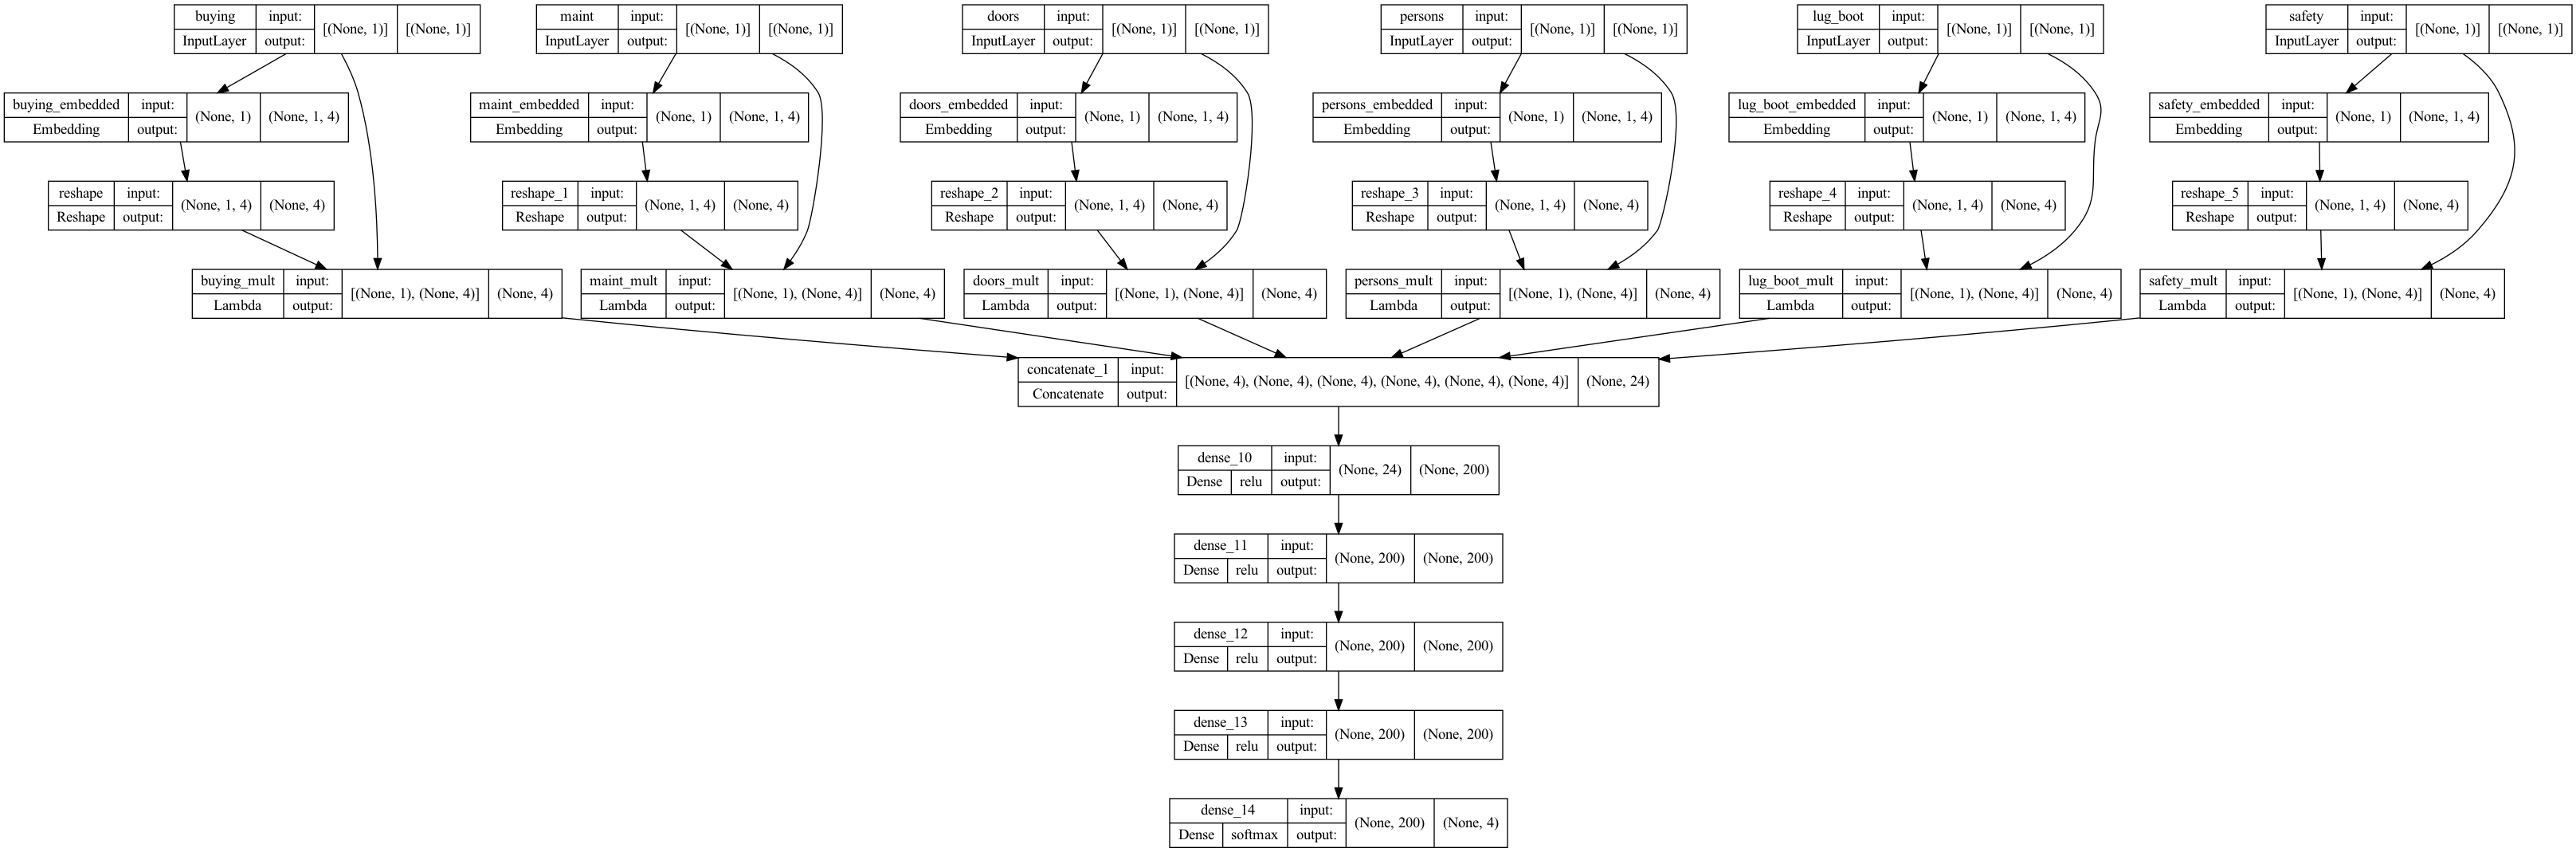

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

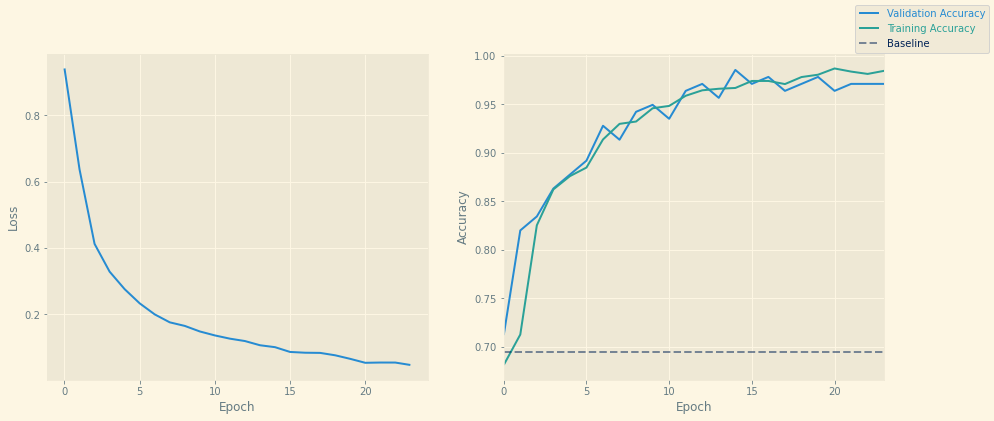

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(history.history["loss"])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlim(left=0, right=history.epoch[-1])
baseline_acc = (np.bincount(y_train) / len(y_train)).max().round(3)
axs[1].axhline(baseline_acc, ls='--', label='Baseline', color='#002255', alpha=0.5)
fig.legend(labelcolor='linecolor')

In [21]:
yh_test = model.predict(x=X_test_preprocessed).argmax(axis=1)
(yh_test == y_test).mean().round(3)

0.968

**Convert one-hot to embedding vectors**

In [22]:
layer = model.get_layer('buying_embedded')
output_concat_embeddings = layer.get_weights()
print(output_concat_embeddings[0])

[[ 0.03621217  0.01101397  0.04033709 -0.01974869]
 [ 0.08789056 -0.07879125 -0.11728548  0.05710517]
 [ 0.00431912 -0.0226206  -0.05763126  0.01274813]
 [-0.02191411  0.03134884  0.03529592 -0.06169997]
 [-0.02037567 -0.04434241  0.03272493 -0.00402693]]


In [23]:
M = output_concat_embeddings[0][:4,:]
M

array([[ 0.03621217,  0.01101397,  0.04033709, -0.01974869],
       [ 0.08789056, -0.07879125, -0.11728548,  0.05710517],
       [ 0.00431912, -0.0226206 , -0.05763126,  0.01274813],
       [-0.02191411,  0.03134884,  0.03529592, -0.06169997]],
      dtype=float32)

In [24]:
pd.get_dummies(X_train["buying"])

,0,1,2,3
1233,0,0,1,0
788,1,0,0,0
216,0,0,0,1
1394,0,1,0,0
1341,0,1,0,0
...,...,...,...,...
1054,0,0,1,0
1723,0,1,0,0
1289,0,0,1,0
1359,0,1,0,0


In [25]:
pd.DataFrame(pd.get_dummies(X_train["buying"]).values.dot(M), columns=["buying_embedded_" + str(i) for i in range(4)], index=X_train.index)

,buying_embedded_0,buying_embedded_1,buying_embedded_2,buying_embedded_3
1233,0.004319,-0.022621,-0.057631,0.012748
788,0.036212,0.011014,0.040337,-0.019749
216,-0.021914,0.031349,0.035296,-0.061700
1394,0.087891,-0.078791,-0.117285,0.057105
1341,0.087891,-0.078791,-0.117285,0.057105
...,...,...,...,...
1054,0.004319,-0.022621,-0.057631,0.012748
1723,0.087891,-0.078791,-0.117285,0.057105
1289,0.004319,-0.022621,-0.057631,0.012748
1359,0.087891,-0.078791,-0.117285,0.057105
